In [25]:
import os
# Install java"
# ! sudo apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [2]:
!pip install --ignore-installed -q pyspark==2.4.5
!gsutil cp gs://hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar /opt/conda/lib/python3.7/site-packages/pyspark/jars/
    
!pip install --ignore-installed spark-nlp==2.5.1
!pip install wordcloud
!pip install vaderSentiment
!pip3 install folium --upgrade
!pip install geojson
!pip install branca

Requirement already up-to-date: folium in /opt/conda/lib/python3.7/site-packages (0.11.0)


In [201]:
import sparknlp
import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import *
from pyspark.sql.functions import explode, col
from pyspark.sql.functions import from_unixtime, to_date, asc, year, udf, explode, split, col, desc, length, rank, dense_rank, avg, sum
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, to_timestamp,date_format
from pyspark import StorageLevel
import pyspark.sql.functions as F
from sparknlp.pretrained import PretrainedPipeline
from collections import Counter
from wordcloud import WordCloud
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,LemmatizerModel, StopWordsCleaner)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import folium
import pandas

def start():
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "40G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1") \
        .config("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
        .config("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")
    return builder.getOrCreate()
spark = start()
spark.version
!ps -ef | grep spark

jupyter   1795  1768 25 15:13 ?        01:20:17 /usr/lib/jvm/java-8-openjdk-amd64/bin/java -cp /opt/conda/lib/python3.7/site-packages/pyspark/conf:/opt/conda/lib/python3.7/site-packages/pyspark/jars/* -Xmx40G org.apache.spark.deploy.SparkSubmit --conf spark.master=local[*] --conf spark.driver.memory=40G --conf spark.kryoserializer.buffer.max=2000M --conf spark.jars.packages=com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1 --conf spark.serializer=org.apache.spark.serializer.KryoSerializer --conf spark.app.name=Spark NLP Licensed --conf fs.AbstractFileSystem.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS --conf fs.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem pyspark-shell
jupyter   3848  1795  0 18:32 ?        00:00:00 python -m pyspark.daemon
jupyter   5848  1768  0 20:32 pts/1    00:00:00 /bin/sh -c ps -ef | grep spark
jupyter   5850  5848  0 20:32 pts/1    00:00:00 grep spark


### Read Tweet Data Set

In [27]:
spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")
spark.conf.set("spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation","true")

In [28]:
def read_tweet_data(month):
    tweet_data_bucket_path = "gs://bucket-covid/TweetData/COVID-19-TweetIDs-master/2020-" + month + "/"
    jan_df = spark.read.json(tweet_data_bucket_path + "coronavirus-tweet-id-2020-" + month + "-*-12.jsonl.gz")
    jan_df = jan_df.select("id", "created_at", "coordinates", "geo", "place", "full_text", "lang")
    jan_df.repartition(20).write.mode('overwrite').saveAsTable(month + "_tweet_data")

In [29]:
# Tweet data. is month was on cloud storage 2020-01, 2020-02 ...
# Current we are reading 1Hour data from each day
months = ['0'+str(i) for i in range(1,7)]
for month in months:
    read_tweet_data(month)

In [46]:
tweet_dfs = []
for month in months:
    m_df = spark.read.parquet("spark-warehouse/" + month + "_tweet_data")
    tweet_dfs.append(m_df)

In [35]:
# Helper function for cleanup
nltk.download('stopwords')
eng_stopwords = stopwords.words('english')

def wordcloud(corpus_sdf):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['text']] = row['count']
        
    word_cloud = WordCloud().generate_from_frequencies(corpus_dict)
    plt.imshow(word_cloud);
    
    
def remove_stopwords(x):    
    sw = stopwords.words("english")
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
    return string


nosw = udf(remove_stopwords)
spark.udf.register("nosw", nosw)

documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords) 

# finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['clean_lemma']) \
    .setCleanAnnotations(False)

pipeline = Pipeline() \
    .setStages([
        documentAssembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        finisher
    ])

# return set of value from file
def get_words_from_file(file_path):
    words = []
    with open(file_path) as fo:
        for word in fo:
            words.append(word.strip())
    return set(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


### Build WordCloud

In [63]:
def createWordCloud(query):
    temp_df = spark.sql(query)
    clean_df = pipeline.fit(temp_df).transform(temp_df) # without stop words
    
    token_df = clean_df.withColumn("exploded_text", explode(col("finished_clean_lemma")))
    token_df.createOrReplaceTempView("cleanTokens")
    
    count_term_df = spark.sql("""select exploded_text as text, count(*) as count from cleanTokens group by exploded_text""")
    count_term_df = token_df.groupby('exploded_text').count().withColumnRenamed("exploded_text", "text")
    
    count_term_df.createOrReplaceTempView("tempView")
    count_term_df_query = 'select text, count from {} where lower(text) not rlike ("corona|coronavirus|covid|get|say|take|make|new|en|el|de|rt|se|le|para|la|los|les|por|di|like|queue|un|es|today|anyone|may|una|also|amp|lo|sus|go|agua|con|get|que|manas") order by count desc limit 100'.format("tempView")
    top_terms_df = spark.sql(count_term_df_query)

    fig, ax = plt.subplots(nrows=1, figsize=(10,10))
    wordcloud(top_terms_df)

In [39]:
analyser = SentimentIntensityAnalyzer()
polarity_score = lambda text: analyser.polarity_scores(text)['compound']

### Get polarity from tweet text 

In [49]:
nosw = udf(remove_stopwords)
spark.udf.register("nosw", nosw)

udfpolarity = udf(polarity_score)
spark.udf.register("udfpolarity", udfpolarity)

def cal_polarity_save(month_index):
    df = tweet_dfs[month_index]
    # Select non null and convert to unixtime
    df = df.where(col("full_text").isNotNull()) \
                .withColumnRenamed("full_text", "text") \
                .withColumn('created_at', from_unixtime(unix_timestamp(col("created_at"), "EEE MMM dd HH:mm:ss ZZZZ yyyy"), "yyyy-MM-dd"))

    # Remove stopwords
    df = df.withColumn('text', nosw('text'))
    # Get polarity of each column
    df = df.withColumn('polarity', udfpolarity("text"))
    return df

# Calcularity polarity for each tweet and save
for i in range(6):
    polarity_df = cal_polarity_save(i)
    polairty_df = polarity_df.select("id", "created_at", "coordinates", "geo", "place", "text", "polarity")
    polairty_df.repartition(20).write.mode('overwrite').saveAsTable('0'+ str(i + 1) + "_TweetsPolarity") # table saved as 01_TweetsPolarity

In [55]:
#  Generate WordCloud
def create_show_wordcloud(month):
    query = """select * from {}""".format('0'+str(month) + "_TweetsPolarity")
    createWordCloud(query)

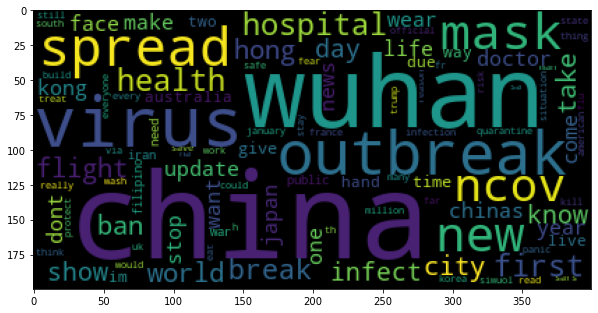

In [56]:
# Show Jan WordCloud
create_show_wordcloud(1)

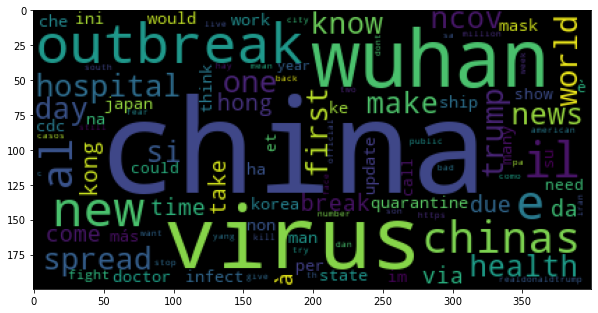

In [57]:
# Show Feb WordCloud
create_show_wordcloud(2)

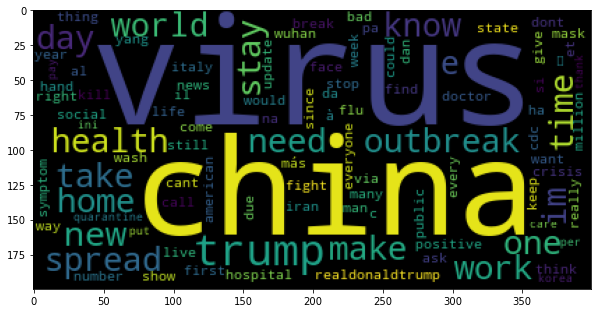

In [58]:
# Show March WordCloud
create_show_wordcloud(3)

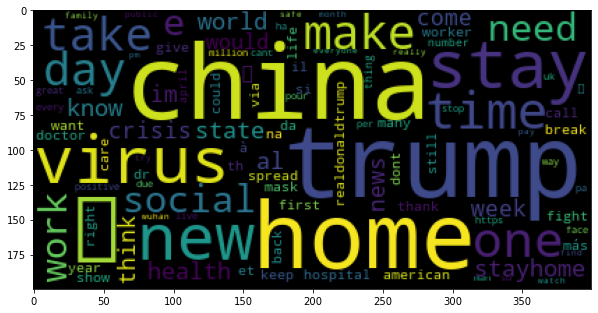

In [59]:
# Show April WordCloud
create_show_wordcloud(4)

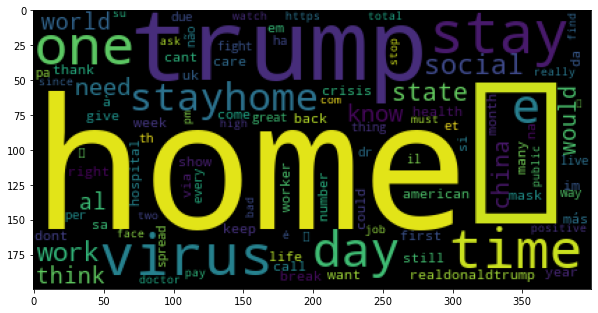

In [64]:
# Show May WordCloud
create_show_wordcloud(5)

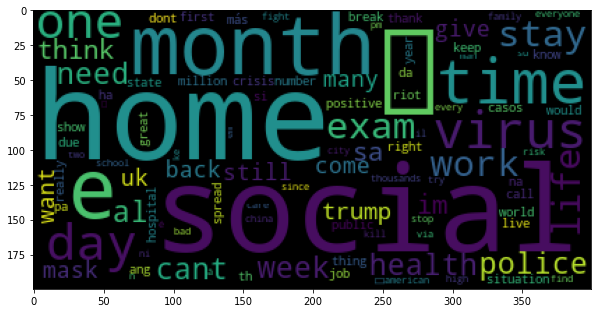

In [65]:
# Show June WordCloud
create_show_wordcloud(6)

### Plot Mental Anxiety

In [75]:
''' 
input : polarity table,  list of terms
return df
'''  
def daily_polarity(table_name, terms):
    terms_matcher = '(' + "'" + '|'.join(terms) + "'" + ')'
    query = "select created_at, count(*) as total_tweet, (sum(polarity)/count(*)) as sentiment from {} where text rlike {} group by created_at order by created_at asc".format(table_name, terms_matcher)
    return spark.sql(query)

In [266]:
jan = "01_TweetsPolarity"
feb = "02_TweetsPolarity"
march = "03_TweetsPolarity"
may = "05_TweetsPolarity"
april = "04_TweetsPolarity"

mental_anxiety_file = "mental_anxiety_terms.txt"
anxiety_terms = get_words_from_file(mental_anxiety_file)

jan_df = daily_polarity(jan, anxiety_terms)
feb_df = daily_polarity(feb, anxiety_terms)
march_df = daily_polarity(march, anxiety_terms)
april_df = daily_polarity(april, anxiety_terms)
may_df = daily_polarity(may, anxiety_terms)


Text(0, 0.5, 'Polarity')

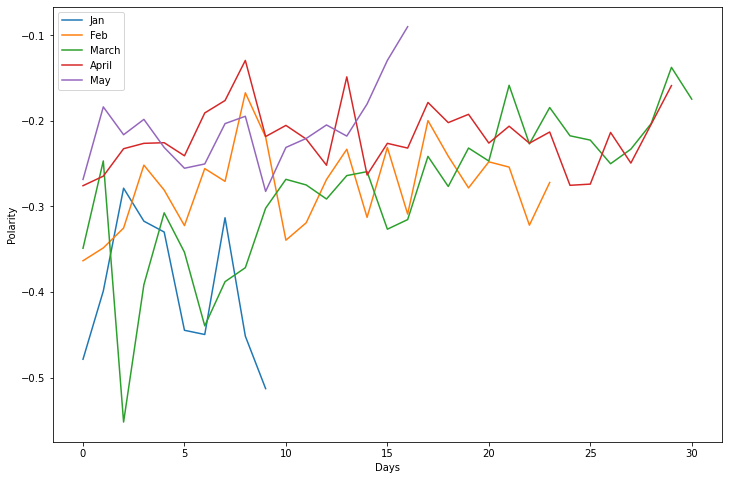

In [282]:
plt.figure(figsize=(12,8))

ax0 = jan_df.toPandas()["sentiment"].plot(label="Jan")
ax1 = feb_df.toPandas()["sentiment"].plot(label="Feb")
ax2 = march_df.toPandas()["sentiment"].plot(label="March")
ax3 = april_df.toPandas()["sentiment"].plot(label="April")
ax4 = may_df.toPandas()["sentiment"].plot(label="May")
plt.legend()
ax4.set_xlabel('Days')
ax4.set_ylabel('Polarity')

### Plot Outbreak 

In [293]:
outbreak_file = "outbreak_terms.txt"

outbreak_terms = get_words_from_file(outbreak_file)
df = daily_polarity("02_TweetsPolarity", outbreak_terms)

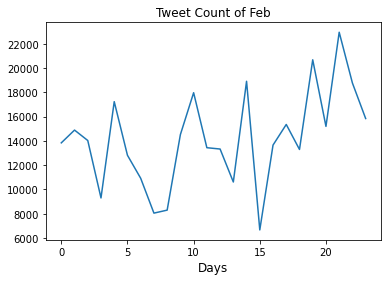

In [294]:
ax = df.toPandas()["total_tweet"].plot(title="Tweet Count of Feb", legend=False)
xlabel = plt.xlabel('Days', fontsize=12)

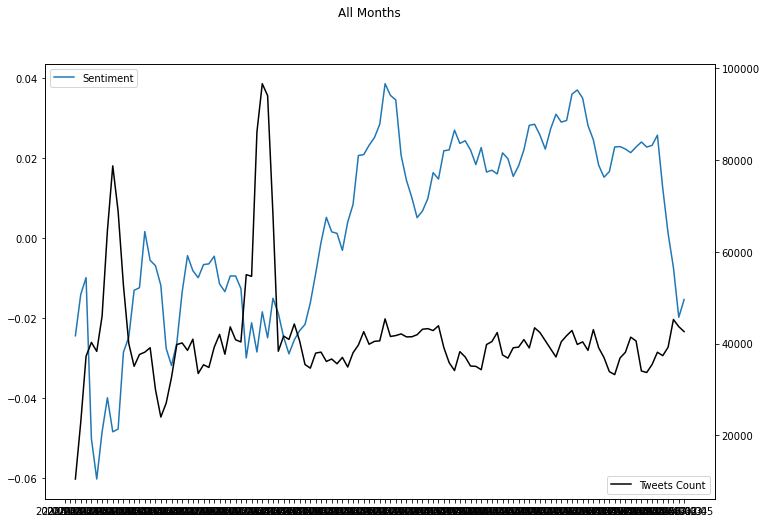

In [290]:
def plot_trend(chart_title, rolling_window=90):
    trend_pdf = all_months_df.select('created_at', 'polarity','id')\
                            .groupby('created_at').agg({'polarity':'avg','id':'count'})\
                            .orderBy('created_at')\
                            .withColumnRenamed('avg(polarity)','polarity')\
                            .withColumnRenamed('count(id)','num_tweets')\
                            .toPandas()
    rolling_sentiment = trend_pdf.polarity.rolling(window=rolling_window).mean()
    rolling_tweets = trend_pdf.num_tweets.rolling(window=rolling_window).mean()
    fig, ax = plt.subplots(figsize=(12,8), sharex=True)
    fig.suptitle('{}'.format(chart_title))
    ax0 = plt.subplot(111)
    ax1 = ax0.twinx()

    ax0.plot(trend_pdf.created_at, rolling_sentiment, label='Sentiment')
    ax0.legend(loc='upper left')
    ax1.plot(trend_pdf.created_at, rolling_tweets, label='Tweets Count', c='k')
    ax1.legend(loc='lower right');
    ax.set_xticklabels(trend_pdf["created_at"], rotation=20, horizontalalignment = 'right')
plot_trend("All Months", 3)

### Geo Location

In [312]:
df = all_months_df.filter("place is not null")

In [296]:
pdf = df.toPandas()

In [297]:
pdf["country"] = [row['country'] for row in pdf["place"]]

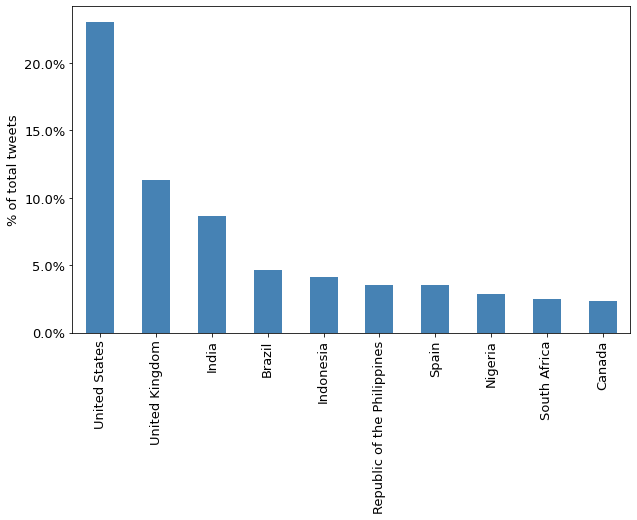

In [298]:
# plot tweets counts by country of origin
top_10_countries = pdf.country.value_counts(1).head(10)
ax = top_10_countries.plot(kind='bar',figsize=(10,6), fontsize=13, color='steelblue')
plt.ylabel('% of total tweets', fontsize=13)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [299]:
geo_pdf = pdf[pdf["geo"].notnull()]

In [300]:
def getGeoJson(pdf):
    features = []
    centroid = False
    for index, row in pdf.iterrows():
        geodata = {
               "type": "Feature",
               "properties": {
                    "name": "Covid Tweet",
                    "marker-size": "small"
                  }
            }
        if row["geo"]:
            geodata["geometry"] = {
                "type": "Point",
                "coordinates": [
                    row["geo"]["coordinates"][1],
                    row["geo"]["coordinates"][0]
                ]}
                
        if "geometry" in geodata:
            features.append(geodata)
            
    geojson = {"type" : "FeatureCollection", "features": features}
    return geojson

In [301]:
cols = ['country', 'polarity']
geo_pdf = geo_pdf[cols]

In [302]:
geo_pdf['polarity'] = geo_pdf['polarity'].astype(float)

In [303]:
country_avg_df = pandas.DataFrame({'polarity' : geo_pdf.groupby(["country"])["polarity"].mean()}).reset_index()

In [ ]:
# Some experiment
import branca.colormap as cm
my_color = cm.LinearColormap(
    ['red', 'pink', 'green'],
    index=[-1.0, 0, 1.0]
)
tweet_dict = country_avg_df.set_index('country')['polarity']
# 'fillColor': colormap(unemployment_dict[feature['id']]),
t = tweet_dict.to_dict()
linear_color = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=3, vmax=10
)
def my_color(feature):
    if feature in t.keys():
       linear_color(feature["properties"]["name"])
geo_df = pandas.read_json(world_geo_json)
geo_df_mod = geo_df[geo_df["features"]["properties"]["name"] in t.keys()]
df = geo_df.to_dict()
# for v in df.values():

geo_data_countries = {}
geo_data_countries["type"] = "FeatureCollection"
geo_data_countries["features"] = []

for k in t.keys():
    for v in df["features"].values():
        if k == v["properties"]["name"]:
            geo_data_countries["features"].append(v)
# geo_df = geo_df[geo_df["features"]["properties"]["name"] in t.keys()]

In [249]:
world_geo_json = r'countries.geo.json'
folium.GeoJson(
    new_json,
    name='polarity',
    style_function=lambda feature: {
        'fillColor': my_color(tweet_dict[feature["properties"]["name"]]),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(m)
m

In [307]:
country_avg_df.shape

(112, 2)

In [222]:
tweet_map = folium.Map(location=[48, 0], zoom_start=2, tiles="OpenStreetMap")

# generate choropleth map 
tweet_map.choropleth(
    geo_data = geo_data_countries,
    data = country_avg_df,
    columns = cols,
    key_on = 'feature.properties.name',
    style_function=lambda feature: {
        'fillColor': my_color(feature.properties.name),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    },
    legend_name='Sentiment Polaity'
    )

tweet_map

In [306]:
# Working
tweet_map = folium.Map(location=[48, 0], zoom_start=2, tiles="OpenStreetMap")
world_geo_json = r'countries.geo.json'

# generate choropleth map 
tweet_map.choropleth(
    geo_data = world_geo_json,
    data = country_avg_df,
    columns = cols,
    key_on = 'feature.properties.name',
    fill_color = 'YlGn', 
    fill_opacity = 0.5, 
    line_opacity = 1,
    smooth_factor=0,
    legend_name='Sentiment Polaity'
    )

tweet_map

/opt/conda/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [ ]:
latitude = 37.0902
longitude = -95.7129
tweet_map = folium.Map(location=[latitude, longitude], zoom_start=5)

In [ ]:
geo_pdf.loc[:, "lat"] = [i[0][1] for i in geo_pdf['coordinates']]
geo_pdf.loc[:, "lon"] = [i[0][0] for i in geo_pdf['coordinates']]
geo_pdf.head(3)

In [ ]:
geo_pdf.head(3)

In [ ]:
for lat, lon, country in zip(geo_pdf['lat'], geo_pdf['lon'], geo_pdf['country']):
    folium.CircleMarker(
        [lat, lon],
        radius = 0.15,
        color='b',
        key_on = 1,
        threshold_scale=[0,1,2,3],
        fill_color='#black',
        fill=True,
        fill_opacity=0.7
        ).add_to(tweet_map)
tweet_map

In [ ]:
kw = {"location": [48, -102], "zoom_start": 2} 
geo_json_str = json.dumps(getGeoJson(geo_pdf), indent = 2)
m = folium.Map(tiles = "OpenStreetMap", **kw)

In [ ]:
map2 = folium.Map(location=[38.9, -77.05], tiles='Stamen Terrain', zoom_start=11)

marker_cluster = folium.MarkerCluster().add_to(map2)

In [ ]:
import folium

m = folium.Map(location=[41.5236, -122.6750])
m

In [ ]:
# SNS experiments
import seaborn as sns; 
sns.set()
data = df.toPandas()
# date = pd.to_datetime(df['event_date'])
ax = sns.lineplot(data=data["total_tweet"])